TITANIC DATASET - ML - DECISION TREE
====================================

In [24]:
%load_ext autoreload
%autoreload 2

import mlflow
import pickle
import pandas as pd 
import numpy as np

from datetime import datetime
from functions import get_metrics

from matplotlib import pyplot as plt 

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configs

In [25]:
EXPERIMENT_TITLE = "Titanic Dataset Analyzes"

run_description = """
### Descrição

Implementação usando [Árvore de Decisão](https://scikit-learn.org/stable/modules/tree.html)
"""

tags = {
    "date": datetime.now(),
    "author": "Pablo Veinberg",
    "version": 1.0,
    "envoronment": "local",
    "mlflow.note.content": run_description,
    "mlflow.runName": "Decision Tree",
    "data_source": "./../datasets/silver/train-encoded-not-normalize.parquet",
    "train_test_dataset": "./../datasets/silver/titanic-train-test-data.pkl"
}

params = {
    "token": np.random.randint(10_000,high=99_000),
    "model_params": {    
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    }
}


## Load data

In [26]:
dataset = pd.read_parquet(tags['data_source'])
mlflow_dataset = mlflow.data.from_pandas(dataset, \
                                            source=tags['data_source'], \
                                            name="Titanic Dataset")

/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/data/dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [27]:
with open('./../datasets/silver/titanic-train-test-data.pkl', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

## Process

Traceback (most recent call last):
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 303, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.e

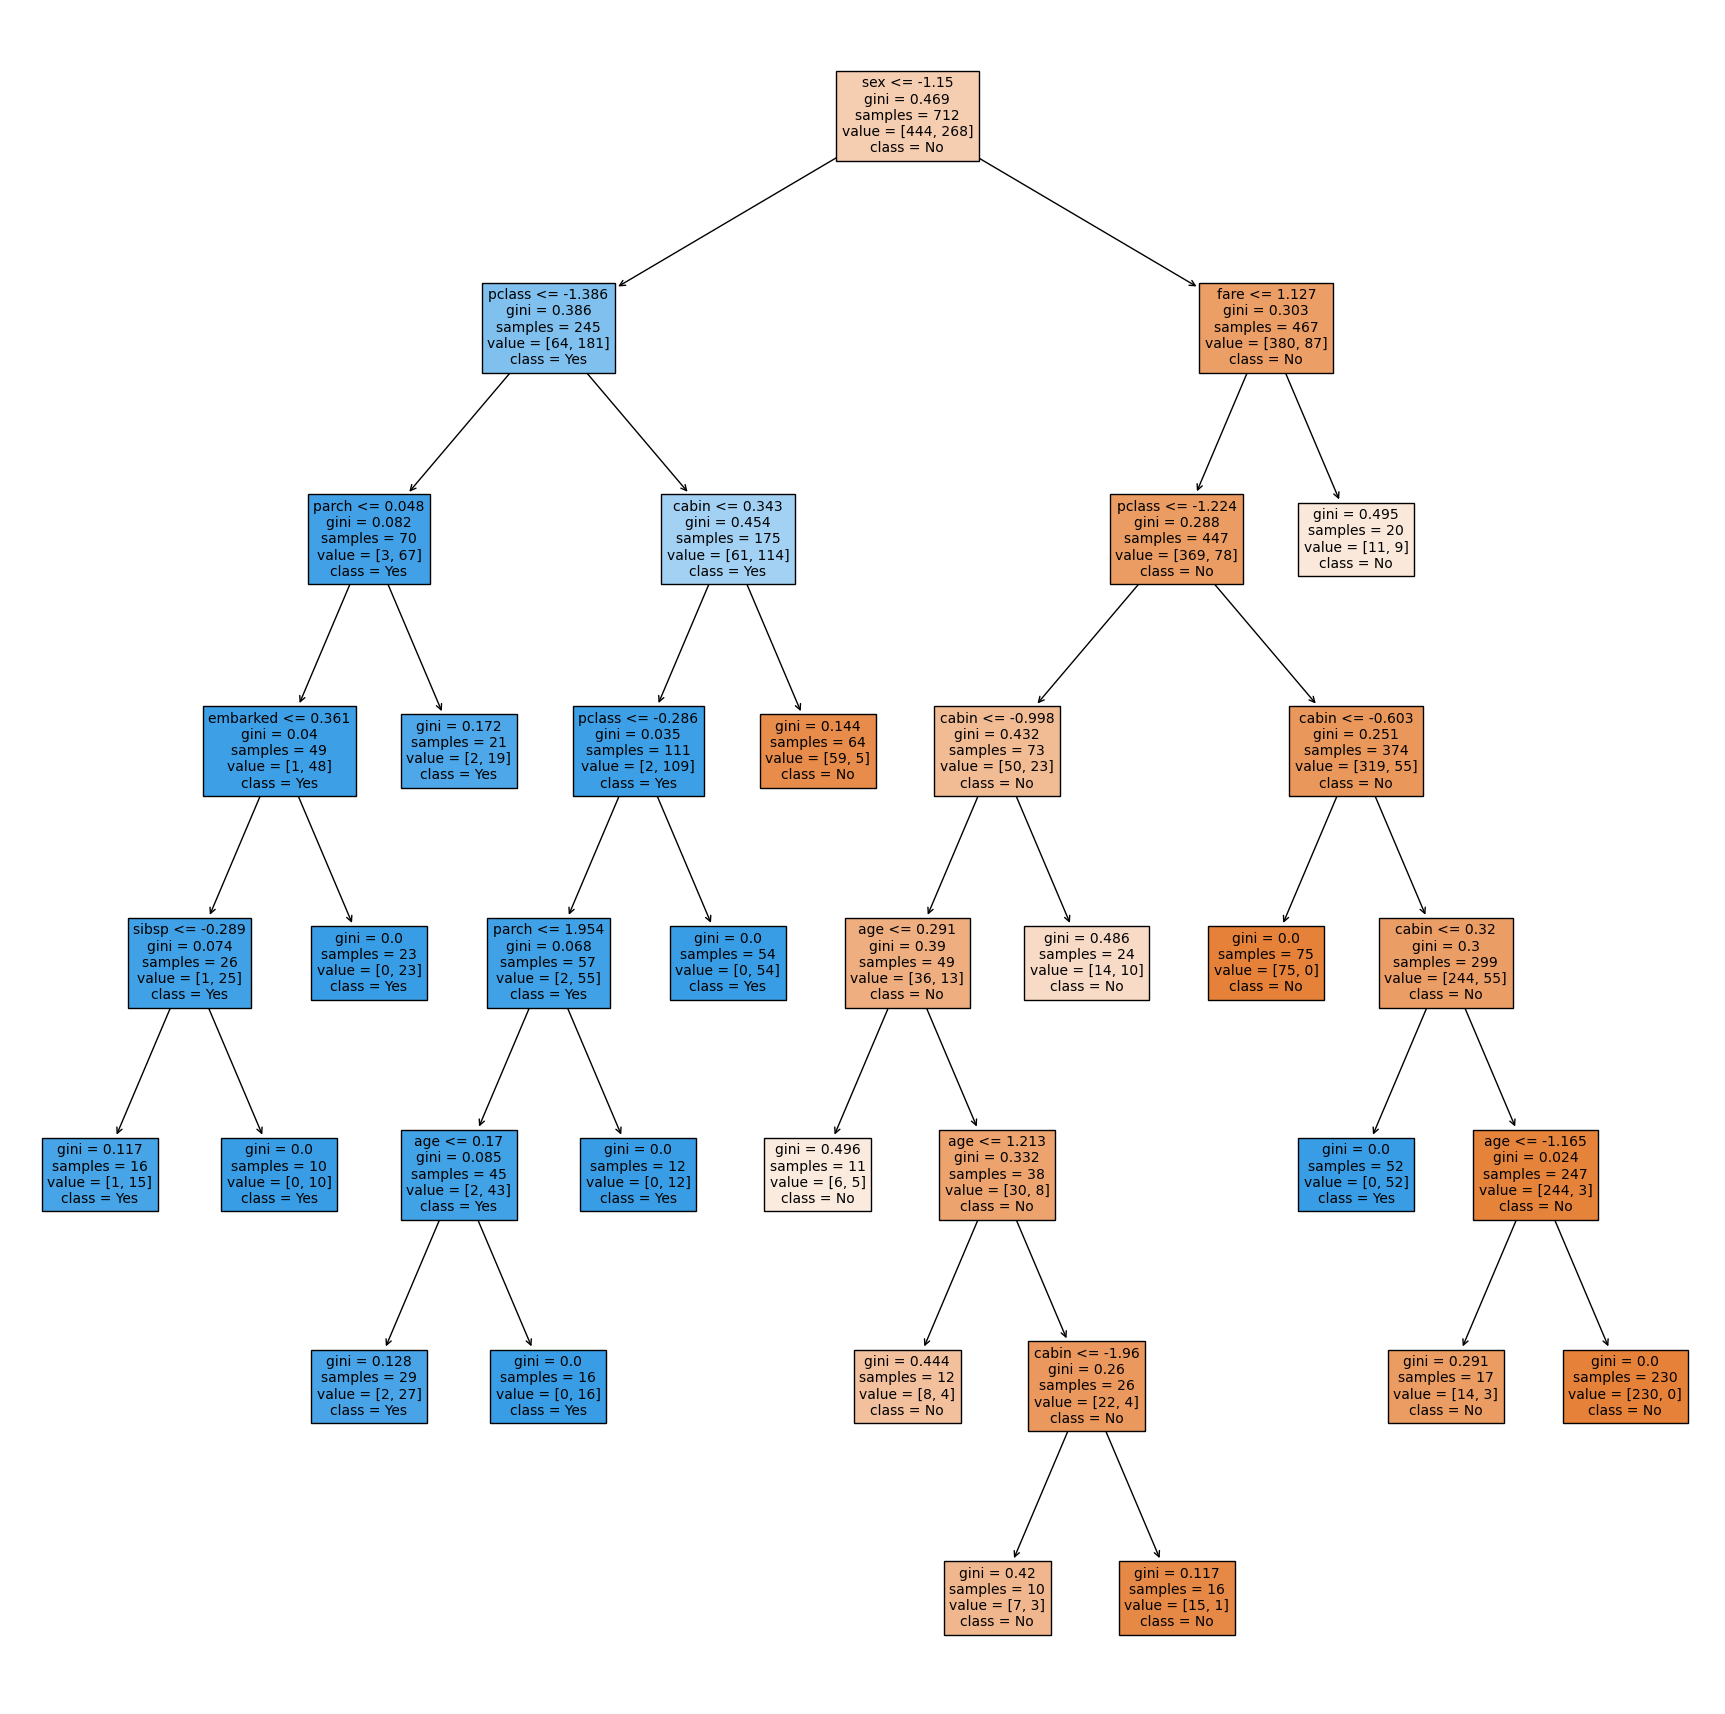

In [28]:
mlflow.set_experiment(EXPERIMENT_TITLE)

with mlflow.start_run():

    # set params
    mlflow.log_input(mlflow_dataset)
    mlflow.set_tags(tags)
    mlflow.log_params(params)

    # train model
    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), \
                            param_grid=params["model_params"])
    
    grid_search.fit(X_train, y_train)
    mlflow.log_param("best_params", grid_search.best_params_)

    model = DecisionTreeClassifier(**grid_search.best_params_)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    classes_str = ['No', 'Yes']
    
    # log metrics
    mlflow.log_param("feature_importances", model.feature_importances_)
    mlflow.log_param("model_classes", classes_str)

    # plot confusion matrix
    plot_confusion_matrix_path = f"./../results/decision_tree_matrix_{params['token']}.png"
    metrics = get_metrics(y_test, y_pred, plot_confusion_matrix_path, "Matrix Confusion - Titanic Dataset")
    
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(plot_confusion_matrix_path)
    
    # plot tree
    plot_tree_path = f"./../results/decision_tree_{params['token']}.png"
    features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked']
    _figure, _axis = plt.subplots(nrows=1, ncols=1, \
                                  figsize=(22,22))
    
    plot_tree(model, feature_names=features, \
            filled=True, \
            class_names=classes_str, \
            fontsize=10)
    
    plt.savefig(plot_tree_path)
    mlflow.log_artifact(plot_tree_path)
    

mlflow.end_run()